# MCMC Bayesian Inference of $M_{\bullet} - M_{\star}$ Relation from z ~ 4-7 JWST Data
### Bao (Tintin) Nguyen
### The University of Arizona / Harvard-Smithsonian Center for Astrophysics
### Updated: September 22, 2023

### This code has been used to generate figure 1 and 2 and the inferred z~5 $M_{\bullet} - M_{\star}$ relation from 21 JWST observations in [Pacucci et al. 2023](https://arxiv.org/abs/2308.12331).

## Intro, JWST data, JWST H$\alpha$ limit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
from scipy import stats
from scipy import optimize
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import random
from scipy.integrate import quadrature as quad

plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['figure.figsize'] = (10,10)

The JWST z~4-7 data comes from [Harikane et al. 2023](https://arxiv.org/abs/2303.11946) (8 sources, excluding GLASS sources), [Übler et al. 2023](https://arxiv.org/abs/2302.06647) (1 source), and [Maiolino et al. 2023](https://arxiv.org/abs/2308.01230) (12 sources, excluding lower-mass ones in candidate dual AGN). $M_{\bullet}$ is inferred from the H$\alpha$ line using the virial relation from equation 5 of [Reines et al. 2013](https://arxiv.org/abs/1308.0328) with the parameters in equation 1 of [Reines & Volonteri 2015](https://arxiv.org/abs/1308.0328).

In [ ]:
def M(L, FWHM):
  return (0.47 * np.log10(L/(10**(42))) + 2.06 * np.log10(FWHM/1000) + 6.6)

FWHM = np.array([2228, 1660, 1794, 2208, 2534, 1739, 6279, 3521])
Lha = np.array([19, 170, 17, 44, 19, 6.4, 3, 1.2]) * 10**(41)

M = np.vectorize(M)

In [ ]:
# Harikane+ 2023

JWST_Mbh = M(Lha, FWHM) # Mbh/Msun (before taking log), recalculated using the equation above
JWST_Mstar = np.array([8.63, 9.11, 9.92, 9.01, 9.35, 9.36, 9.61, 8.94]) # log Mstar/Msun

JWST_Mbh_og = np.array([15, 27, 8.9, 23, 19, 4.9, 46, 8.3]) * 10**(6) # original Mbh value from Harikane+ 2023

# uncertainty above and below of Mbh/Msun, reported in Harikane+ 2023
JWST_Mbh_sigma_above = np.array([1, 7, 4, 7, 6, 3.6, 20, 4.9]) * 10**(6)
JWST_Mbh_sigma_below = np.array([1, 6, 2.3, 6, 5, 2.2, 15, 2.7]) * 10**(6)

# uncertainty above and below of log Mbh/Msun (error propagation)
JWST_Mbh_sigma_above = np.sqrt( JWST_Mbh_sigma_above ** 2 / (JWST_Mbh_og * np.log(10)) ** 2)
JWST_Mbh_sigma_below = np.sqrt( JWST_Mbh_sigma_below ** 2 / (JWST_Mbh_og * np.log(10)) ** 2)

#JWST_Mbh = np.log10 (JWST_Mbh) # log Mbh/Msun

# uncertainty above and below of log Mstar/Msun, note sigma_above = 0 denote upper-limit
JWST_Mstar_sigma_above = np.array([0.63, 0, 0.51, 0, 0, 0.36, 0.77, 0.29])
JWST_Mstar_sigma_below = np.array([1.03, 0.2, 0.68, 0.2, 0.2, 0.45, 1.18, 0.54])

# newer Maiolino+ 2023 data then Ubler 2023

JWST_Mbh = np.concatenate((JWST_Mbh, np.array([7.50, 7.25, 7.36, 6.82, 7.13, 7.30, 7.71, 6.86, 7.22, 6.56, 7.69, 7.90, 8.2])))
JWST_Mstar = np.concatenate((JWST_Mstar, np.array([8.88, 8.45, 8.34, 8.38, 7.79, 8.06, 9.78, 7.87, 8.11, 8.12, 10.18, 10.66, 9.52])))

JWST_Mbh_sigma_above = np.concatenate((JWST_Mbh_sigma_above, np.array([0.307, 0.308, 0.319, 0.381, 0.306, 0.311, 0.301, 0.352, 0.307, 0.319, 0.316, 0.303, 0.4])))
JWST_Mbh_sigma_below = np.concatenate((JWST_Mbh_sigma_below, np.array([0.306, 0.308, 0.313, 0.326, 0.307, 0.311, 0.301, 0.336, 0.311, 0.311, 0.313, 0.303, 0.4])))

JWST_Mstar_sigma_above = np.concatenate((JWST_Mstar_sigma_above, np.array([0.665, 0.033, 0.200, 0.106, 0.300, 0.697, 0.200, 0.157, 0.923, 0.123, 0.127, 0.091, 0.13])))
JWST_Mstar_sigma_below = np.concatenate((JWST_Mstar_sigma_below, np.array([0.665, 0.034, 0.201, 0.146, 0.300, 0.697, 0.200, 0.280, 0.923, 0.132, 0.121, 0.099, 0.13])))

xerr = np.array([JWST_Mstar_sigma_below, JWST_Mstar_sigma_above]) # error bars for x-axis
yerr = np.array([JWST_Mbh_sigma_below, JWST_Mbh_sigma_above]) # error bars for y-axis
xuplims = [False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False] # True means the error is an upper limit, False means otherwise

# redshift
zspec = np.array([4.478, 5.624, 4.483, 5.666, 5.241, 6, 6.936, 4.484]) # Harikane
zspec = np.concatenate((zspec, np.array([5.9193, 4.6482, 5.5951, 5.26894, 4.40935, 4.68123, 4.13317, 5.22943, 5.87461, 5.17241, 4.44802, 6.76026, 5.55]))) #Maiolino and Ubler

Some $M_{\star}$ values are reported as upper limits. Below, we conservatively assign a lower error bar for these values as ranging from the minimum $M_{\star}$ limit of the sample to the data point.

In [ ]:
JWST_Mstar_sigma_below_v2 = np.array([])

for i in range(np.size(JWST_Mstar)):
  cond = xuplims[i]
  if cond:
    value = JWST_Mstar[i] - np.min(JWST_Mstar)
  else:
    value = JWST_Mstar_sigma_below[i]

  JWST_Mstar_sigma_below_v2 = np.append(JWST_Mstar_sigma_below_v2, value)

$\sigma_x$ and $\sigma_y$ are the measurement uncertainties of $M_{\star}$ and $M_{\bullet}$, respectively. $\sigma_{xy}$ is the covariance between uncertainties of $M_{\star}$ and $M_{\bullet}$.

Although the mass uncertainties are reported to be non-Gaussian (i.e., different upper and lower error bars), we model them as Gaussian for simplicity using the greater error bars as a conservative estimate of standard deviations.

In [ ]:
sigma_x = np.maximum(JWST_Mstar_sigma_above, JWST_Mstar_sigma_below_v2)
sigma_y = np.maximum(JWST_Mbh_sigma_above, JWST_Mbh_sigma_below)
sigma_xy = np.cov(sigma_x, sigma_y)[0, -1]

For a medium JWST program (e.g., CEERS and JADES), the sensitivity for a resolution element of the spectrum is $\sim 10^{-19} \, \rm erg \, s^{-1} \, cm^{-2}$.

Considering a resolution element of $\sim 300 \, \rm km \, s^{-1}$, and considering the minimum FWHM for a broad line region (~1000 km/s), the sensitivity on an integrated line is $\approx 1.8\times 10^{-19} \, \rm erg \, s^{-1} \, cm^{-2}$, or $\approx 5.4 \times 10^{-19} \, \rm erg \, s^{-1} \, cm^{-2}$ for a $3\sigma$ detection.

from equation 5 of [Reines et al. 2013](https://arxiv.org/abs/1308.0328) with the parameters in equation 1 of [Reines & Volonteri 2015](https://arxiv.org/abs/1308.0328):

$$ \log M_{\bullet} / M_{\odot} = 0.47 \log \frac{L_{H\alpha}}{10^{42} erg/s} + 2.06 \log \frac{FWHM_{H\alpha}}{1000 km/s} + 6.6$$

Recall that the luminosity L is $4 \pi d_{L}^2 \Phi$, where $\Phi$ is the light flux and $d_{L}$ is the luminosity distance as a function of redshift $z$. For calculation of $d_{L}$, we adopt the standard flat $\lambda$CDM cosmology with $H_0 = 69.3$ km s$^{-1}$ Mpc$^{-1}$, $\Omega_{M} = 0.287$, and $\Omega_{\lambda} = 0.713$ from the 9-year WMAP data ([Hinshaw et al. 2013](https://arxiv.org/pdf/1212.5226.pdf))

By plugging the limiting flux and the minimum FWHM for a broad line region into the expression above, we can get the find the minimum black hole mass that can be detected using the broad H$\alpha$ line. The function below converts the black hole mass to log scale, in solar mass unit.

In [ ]:
def M_min_jwst(z): #Halpha line
  d = (cosmo.luminosity_distance(z).to(u.cm)) / u.cm # luminosity distance as a function of z
  f_min = 5.4e-19 # limiting flux integrated over redshifted freq band
  return (0.47 * np.log10(4*np.pi*d**2*f_min/(10**(42))) + 2.06 * np.log10(1000/1000) + 6.6) # minimum BH mass limit, using eq 1 in Reines & Volonteri 2015

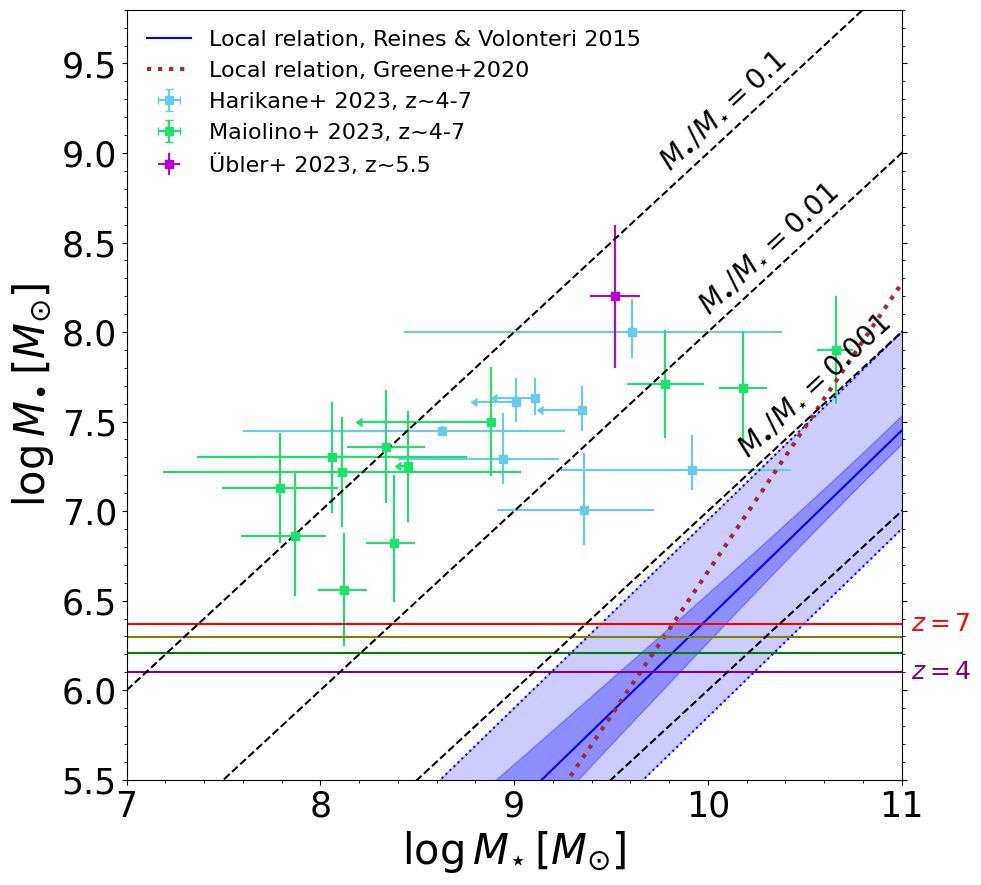

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.set_xlabel(r"$\log M_{\star} \, [M_{\odot}]$")
ax.set_ylabel(r"$\log M_{\bullet} \, [M_{\odot}]$")
#ax.set_title(r"JWST flux limit of $5 \times 10^{-19}$ erg/s/cm$^2$, H$\alpha$ line")

ax.set_xlim(7, 11)
ax.set_ylim(5.5, 9.8)

# data points
plt.errorbar(JWST_Mstar[0:8], JWST_Mbh[0:8], yerr = yerr[:,0:8], xerr = xerr[:,0:8], xuplims = xuplims[0:8], ls = "none", marker = "s", c = np.array([102, 204, 238])/255, label = "Harikane+ 2023, z~4-7") # jwst
plt.errorbar(JWST_Mstar[8:20], JWST_Mbh[8:20], yerr = yerr[:,8:20], xerr = xerr[:,8:20], xuplims = xuplims[8:20], ls = "none", marker = "s", c = np.array([26, 227, 105])/255, label = "Maiolino+ 2023, z~4-7") # jwst
plt.errorbar(JWST_Mstar[20:], JWST_Mbh[20:], yerr = yerr[:,20:], xerr = xerr[:,20:], ls = "none", marker = "s", c = np.array([186, 0, 205])/255, label = "Übler+ 2023, z~5.5") # jwst

# local linear fit, Reines & Volonteri 2015
yint = -4.1
slope = 1.05
xarr = np.arange(7, 11, 0.01)
yarr = yint + slope * xarr
sigma_yarr = (0.08**2 + 0.11**2 * (xarr-11)**2) ** (1/2)


# local linear fit, Reines & Volonteri 2015
yint = -4.1
slope = 1.05
xarr = np.arange(7, 12.5, 0.01)
yarr = yint + slope * xarr
sigma_yarr = (0.08**2 + 0.11**2 * (xarr-11)**2) ** (1/2)
yarr_greene = 7.43 + 1.61 * xarr - 1.61 * (np.log10(3 * 1e10))

ax.plot(xarr, yarr, color = "blue", label = "Local relation, Reines & Volonteri 2015")
ax.plot(xarr, yarr - 0.55, color = "blue", linestyle = "dotted")
ax.plot(xarr, yarr + 0.55, color = "blue", linestyle = "dotted")
plt.fill_between(xarr, yarr - 0.55, yarr + 0.55, color = "blue", alpha = 0.2)
plt.fill_between(xarr, yarr - sigma_yarr, yarr + sigma_yarr, color = "blue", alpha = 0.3)
ax.plot(xarr, yarr_greene, color = "brown", linestyle = "dotted", label = "Local relation, Greene+2020", linewidth = 3)

ax.text(11.05, M_min_jwst(4)-0.04, r'$z = 4$', fontsize = 18, color = "purple")
ax.text(11.05, M_min_jwst(7)-0.04, r'$z = 7$', fontsize = 18, color = "red")

ax.hlines(M_min_jwst(4), 7, 12.5, color = "purple")
ax.hlines(M_min_jwst(5), 7, 12.5, color = "green")
ax.hlines(M_min_jwst(6), 7, 12.5, color = "olive")
ax.hlines(M_min_jwst(7), 7, 12.5, color = "red")

ax.plot(xarr, xarr-1, color = "black", linestyle = "--")
ax.plot(xarr, xarr-2, color = "black", linestyle = "--")
ax.plot(xarr, xarr-3, color = "black", linestyle = "--")
ax.plot(xarr, xarr-4, color = "black", linestyle = "--")

ax.text(9.8, 8.9, r"$M_{\bullet}/M_{\star} = 0.1$", fontsize=20, rotation=45, rotation_mode='anchor', transform_rotates_text=True)
ax.text(10, 8.1, r"$M_{\bullet}/M_{\star} = 0.01$", fontsize=20, rotation=45, rotation_mode='anchor', transform_rotates_text=True)
ax.text(10.2, 7.3, r"$M_{\bullet}/M_{\star} = 0.001$", fontsize=20, rotation=45, rotation_mode='anchor', transform_rotates_text=True)

ax.minorticks_on()
ax.yaxis.set_ticks_position('both')

ax.legend(loc = "upper left", fontsize = 16, framealpha = 0)

## Stellar mass function, z~5

Galaxies are not equally distributed in stellar mass. To estimate the likelihood of JWST detecting hosts at different stellar masses, we use the galaxy stellar mass function (SMF) at z~5 by [Song et al. 2016](https://arxiv.org/pdf/1507.05636.pdf):

$$\phi(M_{\star}, z) = \frac{\phi^{\ast}}{M^{\ast}} \left(\frac{M_{\star}}{M^{\ast}}\right)^{\alpha} \exp{\left(-\frac{M_{\star}}{M^{\ast}}\right)}$$

We only consider the SMF within the stellar mass range observed in the sample (7.79 < $\log M_{\star}/M_{\odot}$ < 10.78)


In [ ]:
ps = 5.16e-5
alpha = -1.70
ms = (10.97)
star_min = np.min(JWST_Mstar)
star_max = np.max(JWST_Mstar)

def SMF(mstar): # Stellar Mass Function, Song+ 2016, z~5

  return (np.log(10) * ps * 10**((mstar-ms)*(1+alpha)) * np.exp(-10**(mstar-ms)))

norm = 1/quad(SMF, star_min, star_max)[0] # normalization constant

In [ ]:
def SMF(mstar): # Stellar Mass Function, Song+ 2016

  if mstar < star_min or mstar > star_max:
    return 0
  else:
    return (np.log(10) * ps * 10**((mstar-ms)*(1+alpha)) * np.exp(-10**(mstar-ms)))*norm

In [ ]:
SMF = np.vectorize(SMF)
quad(SMF, star_min, star_max)[0] # SMF normalized to 1!

1.000000000986304

## MCMC likelihood function / emcee set up

In [ ]:
pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.3 MB/s eta 0:00:00


In [ ]:
pip install corner

In [ ]:
import emcee
import corner
from scipy.stats import multivariate_normal

In [ ]:
ylim = M_min_jwst(5)

The (log-)likelihood function is defined as:
$$\ln {\cal L} = \sum_{i = 1}^{N} \biggr[ \frac{\Delta_{i}^2}{2(\Sigma_{i}^2 + \nu)} - \frac{1}{2} \, \ln (\Sigma_{i}^2 + \nu) + \ln \phi_i \, (x, z = 5) + \ln \eta_i \biggr]$$
where
$$\Delta y_i = y_i - m x_i - b$$
$$\Delta x_i = \Delta y_i \sin \theta \cos \theta$$
$$t_i = [y_{\text{lim}} - m(x_i + \Delta x_i) - b] \sec \theta$$
$$\Delta_{i} = \Delta y_i \cos \theta$$
$$\Sigma_{i} = (\sigma_x^2 \sin^2 \theta + \sigma_y^2 \cos^2 \theta - 2 \sigma_{xy} \sin \theta \cos \theta)^{1/2}$$
$$\eta_i = [1 - F(t_i)]^{-1}$$

$\Delta_i$ is the orthogonal displacement of a data point from the fit line

$\sigma_i^2$ is the orthogonal variance, calculated by projecting the measurement covariance matrix down to the line

$\phi_i$ adds extra weights to sources at lower stellar masses

$\eta_i$ corrects the flux-limited bias of JWST for the $H_{\alpha}$ line

$\nu$ is the variance characterizing the orthogonal intrinsic scatter.

$\Delta_i$ and $\sigma_i$ are further explained in [Hogg 2010](https://arxiv.org/pdf/1008.4686.pdf) while the other modifications $\phi_i$ and $\eta_i$ are further explained in [Pacucci et al. 2023](https://arxiv.org/abs/2308.12331) and Nguyen et al. 2023 (in prep.). Refer to [Pacucci et al. 2023](https://arxiv.org/abs/2308.12331) and Nguyen et al. 2023 (in prep.) for other variables.

In [ ]:
def log_likelihood(theta, x, y, sigma_x, sigma_y, sigma_xy):
  b, m, V = theta # sigma_x and sigma_y are variance, #sigma_xy is covariance

  # theta is angle between the relation and the x-axis
  cos_theta = 1/(np.sqrt(1 + m ** 2))
  sin_theta = m * cos_theta
  delta_y = y - (m * x + b)

  # orthogonal displacement from each point to the relation
  delta_sq = ((delta_y) * cos_theta) ** 2

  # orthogonal projection of covariance matrix
  gamma_sq = (sigma_x * sin_theta) ** 2 + (sigma_y * cos_theta) ** 2 - 2 * sigma_xy * cos_theta * sin_theta

  delta_x = delta_y * cos_theta * sin_theta
  new_x = x + delta_x

  z_value = ((ylim - (m * new_x + b)) / (cos_theta)) / np.sqrt(gamma_sq + V)

  factor = 1/stats.norm.sf(z_value)

  return np.nansum(np.log(SMF(x)) + np.log(factor) - (1/2) * np.log(gamma_sq + V) - (1/2) * (delta_sq/(gamma_sq + V)))

For the prior, we use the local relation parameters (y-intercept b and slope m) derived by [Reines & Volonteri 2015](https://arxiv.org/pdf/1508.06274v2.pdf). We use a flat prior for the intrinsic scatter variance $0 < \nu < 1$, which is a reasonable prior guess.

In [ ]:
var_yint = 0.11**2 * 11**2 + 0.08**2
pmu = np.array([-4.1, 1.05])
psigma = np.array([[var_yint, 0], [0, 0.11**2]])
multi_norm = multivariate_normal(mean=pmu, cov=psigma)
def log_prior(theta):
  m, b, V = theta

  if V < 0 or V > 1:
    return -np.inf
  else:
    return np.log(multi_norm.pdf([m, b]))

Probability = Likelihood x Prior, so we just add them in log.

In [ ]:
def log_probability(theta, x, y, sigma_x, sigma_y, sigma_xy):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sigma_x, sigma_y, sigma_xy)

## MCMC implementation

The parameters are initialized using the local relation parameters in MCMC.

In [ ]:
pos = np.array([-4.1, 1.05, 0.24**2]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(JWST_Mstar, JWST_Mbh, sigma_x, sigma_y, sigma_xy)
)

The MCMC is stopped when either the autocorrelation time converges within 0.1% or the algorithm has finished 10,000 steps

In [ ]:
max_n = 10000
# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.001)
    if converged:
        break
    old_tau = tau

100%|██████████| 10000/10000 [02:41<00:00, 61.89it/s]


Convergence plot:

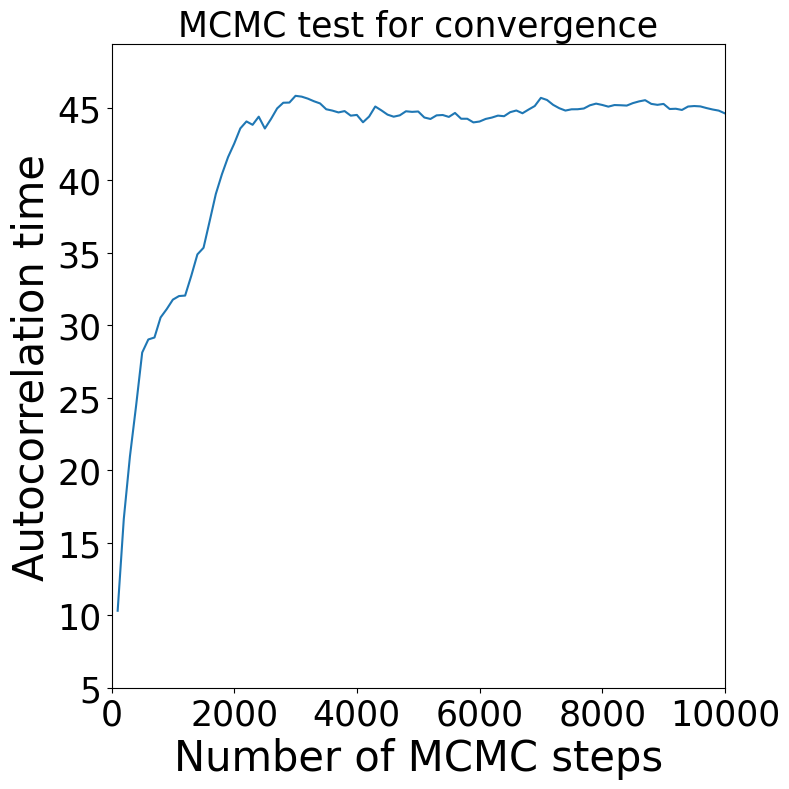

In [ ]:
fig, ax = plt.subplots(1, 1,
                        figsize =(8, 8),
                        tight_layout = True)
ax.set_title("MCMC test for convergence", fontsize = 25)
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
#plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(5, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("Number of MCMC steps")
plt.ylabel(r"Autocorrelation time");

We ignore the first ~1% of samples to avoid bias from the initialization (burn-in period).

In [ ]:
tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
flat_samples = sampler.get_chain(discard=burnin, flat=True)

b_lower, b, b_upper = np.percentile(flat_samples[:, 0], [16, 50, 84])
m_lower, m, m_upper = np.percentile(flat_samples[:, 1], [16, 50, 84])
V_lower, V, V_upper = np.percentile(flat_samples[:, 2], [16, 50, 84])

Posterior distribution:

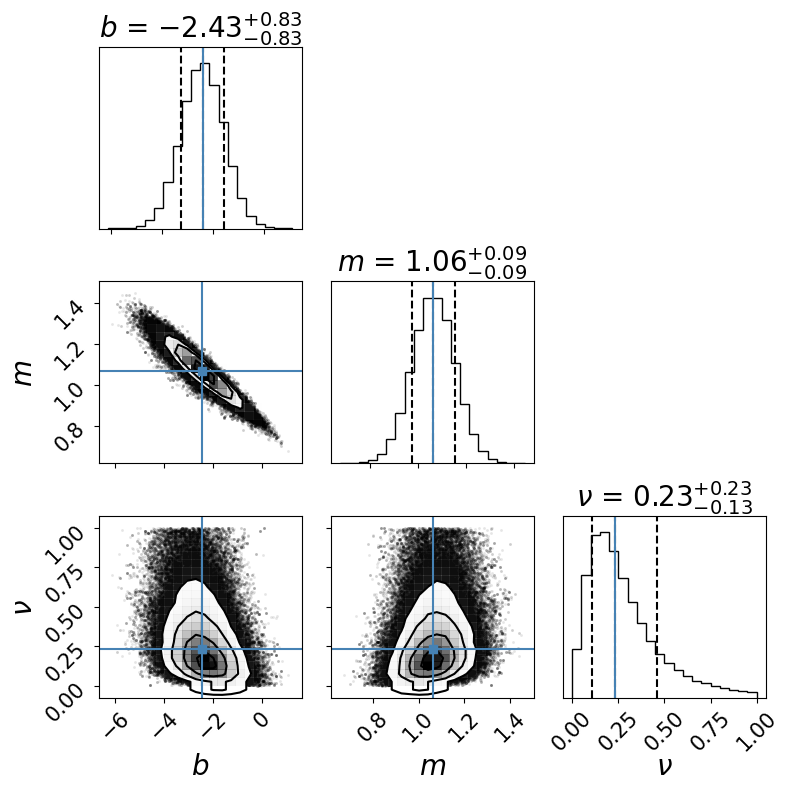

In [ ]:
labels = [r"$b$", r"$m$", r"$\nu$"]

fig, ax = plt.subplots(3, 3,
                        figsize =(8, 8),
                        tight_layout = True)

#fig.suptitle("MCMC posterior distribution", fontsize = 25)
fig = corner.corner(flat_samples,show_titles=True,
                    labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84],
                    label_kwargs={"fontsize": 20}, title_kwargs={"fontsize": 20},
                    truths=[b, m, V], fig=fig)
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=15)

Sample_walkers method below samples 1000 random fits tested by the MCMC algorithm. Then, it quotes the standard deviation of these 1000 random fits as the uncertainty of the final MCMC fit.

In [ ]:
def model(theta, xarr):
  yint, slope, V = theta
  return yint + slope * (xarr)

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i, xarr)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread

med_model, spread = sample_walkers(1000,flat_samples)

In [ ]:
yarr_mcmc = xarr * m + b

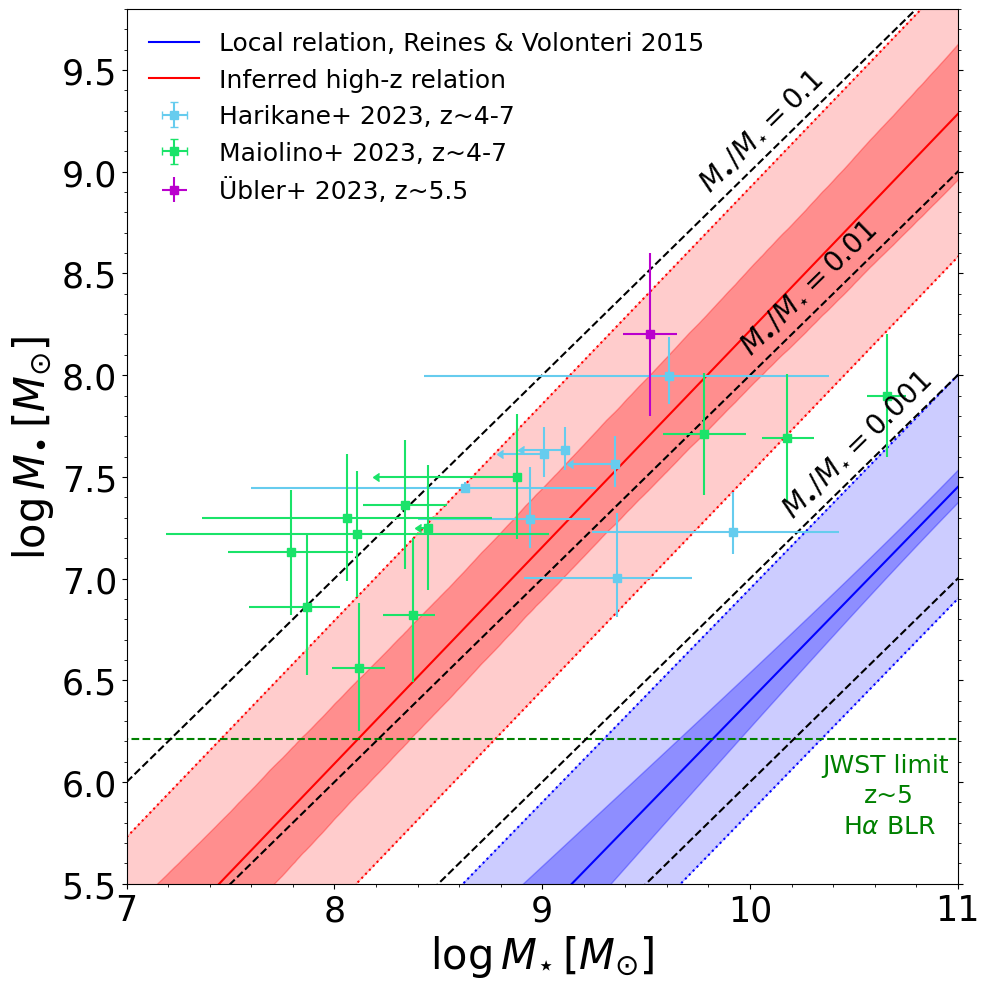

In [ ]:
fig, ax = plt.subplots(1, 1,
                        figsize =(10, 10),
                        tight_layout = True)

ax.set_xlim(7, 11)
ax.set_ylim(5.5, 9.8)

ax.text(9.8, 8.9, r"$M_{\bullet}/M_{\star} = 0.1$", fontsize=20, rotation=45, rotation_mode='anchor', transform_rotates_text=True)
ax.text(10, 8.1, r"$M_{\bullet}/M_{\star} = 0.01$", fontsize=20, rotation=45, rotation_mode='anchor', transform_rotates_text=True)
ax.text(10.2, 7.3, r"$M_{\bullet}/M_{\star} = 0.001$", fontsize=20, rotation=45, rotation_mode='anchor', transform_rotates_text=True)

ax.set_xlabel(r"$\log M_{\star} \, [M_{\odot}]$")
ax.set_ylabel(r"$\log M_{\bullet} \, [M_{\odot}]$")

ax.plot(xarr, yarr, color = "blue", label = "Local relation, Reines & Volonteri 2015")
ax.plot(xarr, yarr - 0.55, color = "blue", linestyle = "dotted")
ax.plot(xarr, yarr + 0.55, color = "blue", linestyle = "dotted")
plt.fill_between(xarr, yarr - 0.55, yarr + 0.55, color = "blue", alpha = 0.2)
plt.fill_between(xarr, yarr - sigma_yarr, yarr + sigma_yarr, color = "blue", alpha = 0.3)

ax.plot(xarr, yarr_mcmc, color = "red", label = "Inferred high-z relation")
ax.plot(xarr, yarr_mcmc - (np.sqrt(1+m**2)*np.sqrt(V)), color = "red", linestyle = "dotted")
ax.plot(xarr, yarr_mcmc + (np.sqrt(1+m**2)*np.sqrt(V)), color = "red", linestyle = "dotted")
#ax.plot(xarr, b_ls + m_ls * xarr, color = "purple", label = "Least square fit of data")
ax.hlines(M_min_jwst(5), 0, 12, color = "green", linestyle = "dashed")

plt.fill_between(xarr, med_model - spread, med_model + spread, color = "red", alpha = 0.3)
plt.fill_between(xarr, yarr_mcmc - (np.sqrt(1+m**2)*np.sqrt(V)), yarr_mcmc + (np.sqrt(1+m**2)*np.sqrt(V)), color = "red", alpha = 0.2)


ax.plot(xarr, xarr-1, color = "black", linestyle = "--")
ax.plot(xarr, xarr-2, color = "black", linestyle = "--")
ax.plot(xarr, xarr-3, color = "black", linestyle = "--")
ax.plot(xarr, xarr-4, color = "black", linestyle = "--")

plt.errorbar(JWST_Mstar[0:8], JWST_Mbh[0:8], yerr = yerr[:,0:8], xerr = xerr[:,0:8], xuplims = xuplims[0:8], ls = "none", marker = "s", c = np.array([102, 204, 238])/255, label = "Harikane+ 2023, z~4-7") # jwst
plt.errorbar(JWST_Mstar[8:20], JWST_Mbh[8:20], yerr = yerr[:,8:20], xerr = xerr[:,8:20], xuplims = xuplims[8:20], ls = "none", marker = "s", c = np.array([26, 227, 105])/255, label = "Maiolino+ 2023, z~4-7") # jwst
plt.errorbar(JWST_Mstar[20:], JWST_Mbh[20:], yerr = yerr[:,20:], xerr = xerr[:,20:], ls = "none", marker = "s", c = np.array([186, 0, 205])/255, label = "Übler+ 2023, z~5.5") # jwst

ax.text(10.35, 6.05, r"JWST limit", color = "green", fontsize=18)
ax.text(10.55, 5.9, r"z~5", color = "green", fontsize=18)
ax.text(10.45, 5.75, r"H$\alpha$ BLR", color = "green", fontsize=18)

ax.minorticks_on()
ax.yaxis.set_ticks_position('both')

ax.legend(loc = "upper left", fontsize = 18, framealpha = 0)

The orthogonal intrinsic scatter is: $\sqrt{\nu} \approx$ = 0.48 dex.

The standard (vertical) intrinsic scatter is: $\sqrt{\nu} \sec \theta = \sqrt{\nu (1+ m^2)} \approx$ 0.7 dex, where $\theta$ defines the angle between the fit line and the x-axis.


In [ ]:
np.sqrt(V)

0.481334104574839

In [ ]:
np.sqrt(1+m**2)*np.sqrt(V)

0.7029807382829566